# Fine Tune BERT for Multi-label Classification
**Based on work from:** [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb)

Using hugging faces' BERT model, I will be training it to classify a string based on multiples classes.

In [1]:
from text_gen_model import TextGenModelManager
from transformers import AutoModelForCausalLM, GenerationConfig, PreTrainedTokenizerFast, AutoTokenizer
from datasets import load_dataset, DatasetDict
import pandas as pd
import numpy as np

/home/cstainsby/class/dataProj/bonion/src/backend_model_service/model_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [2]:
# just to view the head of the data
class_df = pd.read_csv("./saved_data/hot_encoded_class.csv")
class_df.head()

,prompt,nta,yta,info,nah,esh,ywbta
0,title: (UPDATE) AITA for telling my step-daugh...,1,0,0,0,0,0
1,title: AITA (22M) for telling my mom (46F) to ...,1,0,0,0,0,0
2,title: AITA (31F) for not wanting to go out dr...,1,0,0,0,0,0
3,title: AITA (39F) for NOT wanting to move to L...,1,0,0,0,0,0
4,title: AITA (F25) for telling my bridesmaid (F...,1,0,0,0,0,0


In [3]:
del class_df

In [4]:
dataset = load_dataset("csv", data_files="./saved_data/hot_encoded_class.csv")

Found cached dataset csv (/home/cstainsby/.cache/huggingface/datasets/csv/default-76333b3cc915cf8c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|██████████| 1/1 [00:00<00:00, 442.20it/s]


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'nta', 'yta', 'info', 'nah', 'esh', 'ywbta'],
        num_rows: 920
    })
})

In [6]:
example_row = dataset["train"][0]
example_row

{'prompt': 'title: (UPDATE) AITA for telling my step-daughter to “go ask her real dad” when she asked me to pay for her plane tickets?\ncontent: [Original post ](https://www.reddit.com/r/AmItheAsshole/comments/irxyza/aita_for_telling_my_stepdaughter_to_go_ask_her/?utm_source=share&utm_medium=ios_app&utm_name=iossmf)\n\nHey guys. It’s been a good 2 weeks since I’ve posted and I figured you guys would like an update. A lot has happened since the last time I posted\n\nSo that night, I did what many of the comments suggested I do, which was to apologize. I told her that I’m sorry that implying that I’m not her real father, but like it or not that I consider her MY daughter. That I loved her and will always be there for her. She started to cry and sob uncontrollably and said “Why doesn’t he [her biological father] love me?” I held her and told her she didn’t need to fight for his approval. I also apologized for looking through her phone; that I’ve come to accept that it’s not an appropriate

In [7]:
dataset["train"]

Dataset({
    features: ['prompt', 'nta', 'yta', 'info', 'nah', 'esh', 'ywbta'],
    num_rows: 920
})

In [8]:
labels = [label for label in dataset["train"].features.keys() if label not in ["prompt"]]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['nta', 'yta', 'info', 'nah', 'esh', 'ywbta']

## Preprocess Data
You cant pass direct text into BERT, it takes input ids. To get these, we must tokenize the data.

In [9]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [10]:
text = example_row["prompt"]
print(type(text))
encoding = tokenizer.encode(text, padding="max_length", truncation=True, max_length=128)
encoding

<class 'str'>


[101,
 2516,
 1024,
 1006,
 10651,
 1007,
 9932,
 2696,
 2005,
 4129,
 2026,
 3357,
 1011,
 2684,
 2000,
 1523,
 2175,
 3198,
 2014,
 2613,
 3611,
 1524,
 2043,
 2016,
 2356,
 2033,
 2000,
 3477,
 2005,
 2014,
 4946,
 9735,
 1029,
 4180,
 1024,
 1031,
 2434,
 2695,
 1033,
 1006,
 16770,
 1024,
 1013,
 1013,
 7479,
 1012,
 2417,
 23194,
 1012,
 4012,
 1013,
 1054,
 1013,
 26445,
 10760,
 12054,
 11484,
 1013,
 7928,
 1013,
 20868,
 18037,
 4143,
 1013,
 9932,
 2696,
 1035,
 2005,
 1035,
 4129,
 1035,
 2026,
 1035,
 3357,
 2850,
 18533,
 2121,
 1035,
 2000,
 1035,
 2175,
 1035,
 3198,
 1035,
 2014,
 1013,
 1029,
 21183,
 2213,
 1035,
 3120,
 1027,
 3745,
 1004,
 21183,
 2213,
 1035,
 5396,
 1027,
 16380,
 1035,
 10439,
 1004,
 21183,
 2213,
 1035,
 2171,
 1027,
 16380,
 6491,
 2546,
 1007,
 4931,
 4364,
 1012,
 2009,
 1521,
 1055,
 2042,
 1037,
 2204,
 1016,
 3134,
 2144,
 1045,
 1521,
 2310,
 102]

In [11]:
tokenizer.decode(encoding)

'[CLS] title : ( update ) aita for telling my step - daughter to “ go ask her real dad ” when she asked me to pay for her plane tickets? content : [ original post ] ( https : / / www. reddit. com / r / amitheasshole / comments / irxyza / aita _ for _ telling _ my _ stepdaughter _ to _ go _ ask _ her /? utm _ source = share & utm _ medium = ios _ app & utm _ name = iossmf ) hey guys. it ’ s been a good 2 weeks since i ’ ve [SEP]'

In [12]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["prompt"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [13]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Loading cached processed dataset at /home/cstainsby/.cache/huggingface/datasets/csv/default-76333b3cc915cf8c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-36e0aed07e129960.arrow


In [14]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 920
    })
})

### Split Dataset
Split the dataset into a training, validation, and testing dataset 

In [15]:
# 90% train + valid, 10% test
trainvalid_test_dataset = encoded_dataset["train"].train_test_split(test_size=0.2)

trainvalid_dataset = trainvalid_test_dataset["train"]
train_valid_dataset =  trainvalid_dataset.train_test_split(test_size=0.1)


train_test_valid_dataset = DatasetDict({
   'train': trainvalid_test_dataset["train"],
   'test': trainvalid_test_dataset['test'],
   'validation': train_valid_dataset['test']})
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 736
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 184
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
})

## Define the Model

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Train the Model

In [17]:
batch_size = 8
metric_name = "f1"

In [18]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [19]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [20]:
encoded_dataset['train'][0]['labels']

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
encoded_dataset['train']['input_ids'][0]

[101,
 2516,
 1024,
 1006,
 10651,
 1007,
 9932,
 2696,
 2005,
 4129,
 2026,
 3357,
 1011,
 2684,
 2000,
 1523,
 2175,
 3198,
 2014,
 2613,
 3611,
 1524,
 2043,
 2016,
 2356,
 2033,
 2000,
 3477,
 2005,
 2014,
 4946,
 9735,
 1029,
 4180,
 1024,
 1031,
 2434,
 2695,
 1033,
 1006,
 16770,
 1024,
 1013,
 1013,
 7479,
 1012,
 2417,
 23194,
 1012,
 4012,
 1013,
 1054,
 1013,
 26445,
 10760,
 12054,
 11484,
 1013,
 7928,
 1013,
 20868,
 18037,
 4143,
 1013,
 9932,
 2696,
 1035,
 2005,
 1035,
 4129,
 1035,
 2026,
 1035,
 3357,
 2850,
 18533,
 2121,
 1035,
 2000,
 1035,
 2175,
 1035,
 3198,
 1035,
 2014,
 1013,
 1029,
 21183,
 2213,
 1035,
 3120,
 1027,
 3745,
 1004,
 21183,
 2213,
 1035,
 5396,
 1027,
 16380,
 1035,
 10439,
 1004,
 21183,
 2213,
 1035,
 2171,
 1027,
 16380,
 6491,
 2546,
 1007,
 4931,
 4364,
 1012,
 2009,
 1521,
 1055,
 2042,
 1037,
 2204,
 1016,
 3134,
 2144,
 1045,
 1521,
 2310,
 102]

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [23]:
trainer.train()

/home/cstainsby/class/dataProj/bonion/src/backend_model_service/model_env/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=460, training_loss=0.2872388756793478, metrics={'train_runtime': 1497.1631, 'train_samples_per_second': 2.458, 'train_steps_per_second': 0.307, 'total_flos': 242070864445440.0, 'train_loss': 0.2872388756793478, 'epoch': 5.0})

In [24]:
trainer.evaluate()

{'eval_loss': 0.2376590222120285,
 'eval_f1': 0.6666666666666667,
 'eval_roc_auc': 0.7824324324324324,
 'eval_accuracy': 0.6081081081081081,
 'eval_runtime': 8.2922,
 'eval_samples_per_second': 8.924,
 'eval_steps_per_second': 1.206,
 'epoch': 5.0}

In [25]:
predictions, label_ids, metrics = trainer.predict(train_test_valid_dataset["test"])

In [26]:
import matplotlib.pyplot as plt 


In [27]:
def id_matrix_to_label_list(label_matrix):
    id_list = []
    for label_pred_row in label_matrix:
        index = list(label_pred_row).index(1)
        id = id2label[index]
        id_list.append(id)
    return id_list

def count_frequency(lst):
    freq_dict = {}
    for value in lst:
        if value in freq_dict:
            freq_dict[value] += 1
        else:
            freq_dict[value] = 1
    return freq_dict

def merge_dicts(dict1, dict2):
    merged_dict = dict1.copy()
    for key, value in dict2.items():
        if key in merged_dict:
            merged_dict[key] = (merged_dict[key], value)
        else:
            merged_dict[key] = value
    return merged_dict


In [41]:
real = np.array(id_matrix_to_label_list(train_test_valid_dataset["test"]["labels"]))
predicted = np.array(id_matrix_to_label_list(label_ids))

real_freq = count_frequency(real)
predicted_freq = count_frequency(predicted)

total_freqs = merge_dicts(real_freq, predicted_freq)

Text(0.5, 1.0, 'Frequency of Values in Predicted')

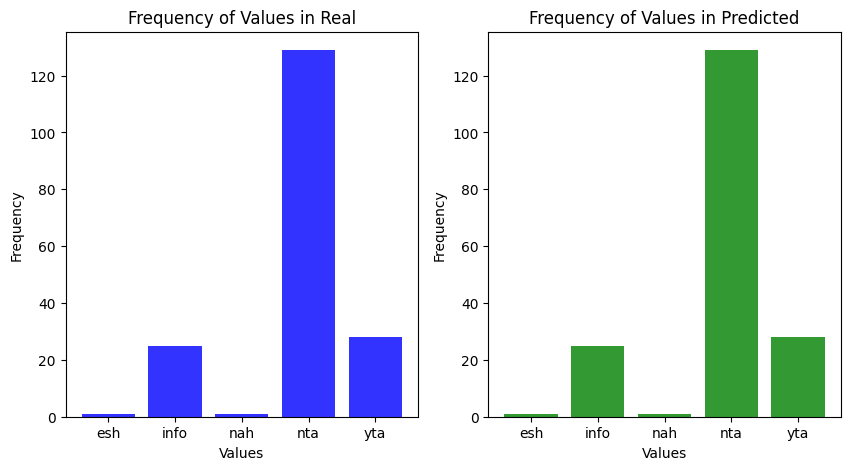

In [37]:
unique_values1, value_counts1 = np.unique(real, return_counts=True)

# Find unique values and their frequencies in arr2
unique_values2, value_counts2 = np.unique(predicted, return_counts=True)

# Plot the histograms side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(unique_values1, value_counts1, color='b', alpha=0.8)
axs[1].bar(unique_values2, value_counts2, color='g', alpha=0.8)

# Add labels and title
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency of Values in Real')

axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency of Values in Predicted')

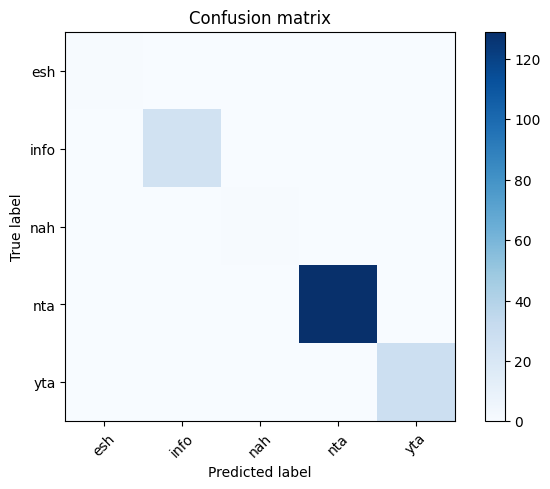

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example true labels and predicted labels

# Compute the confusion matrix
cm = confusion_matrix(real, predicted)
cm_labels = ["esh", "info", "nah", "nta", "yta"]

# Define class labels
class_names = cm_labels

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show the plot
plt.show()


## Test it Out

In [46]:
text = """On Friday after my workout I was on FaceTime with my girlfriend. After my shower I was brushing my teeth and other hygiene stuff. Out of nowhere she says something like “put some clothes on you still look tiny” and I said if I’m skinny then she is fat. We are both pretty much the opposite of those things so obviously they were jokes. Even though both jokes were ass I at least gave her a little ahhaha before I said what I said. What do I get for my joke??? Called childish and Blocked. Literally until a couple hours ago I was blocked the whole weekend.

So now today we were on our way to our first period class and she was ignoring me and wouldn’t talk to me in the hallway. When we got in the classroom she goes and tells the teacher that I’m harassing her. The teacher sends me to the office and she literal smirks at me on my way out while the teacher is calling the office so I know she was being petty.

I’m in the office and the principal and counselor are giving me this pointless ass lecture trying to make it seem like I was creeping on her or something. Anyway I had in school suspension(ISS) and detention after school for today.

She unblocked me and said if I had apologized she wouldn’t be mad anymore and it wasn’t actually what I said it was how I said it. I left her on read because I had no idea wtf she was talking abt at the end that doesn’t even make sense and I will admit that I was kinda in my feelings about the whole harassing thing. Anyway, I came here because when I was telling my boys I got nothing but horrible takes and the advice was even worse. It was so bad that I literally left the gc.

Btw I’m about to go to her house in about less than 2 hours. So we may or may not talk in person tonight."""

In [47]:
encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [48]:
logits = outputs.logits
logits.shape

torch.Size([1, 6])

In [49]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['nta']


## Save the Model For Later Use

In [50]:
trainer.save_model("./saved_models/store/AITAclassmodel/")